# Example: RNA Folding on the Dynex Platform

In biology and chemistry, the properties of a molecule are not solely determined by a set of atoms but also by the shape of the molecule. In genetics, the shape of an RNA molecule is largely determined by how it bends back on itself. The sequence of A’s, U’s, G’s, and C’s that make up RNA has certain pairs that are drawn together to form hydrogen bonds. A sequence of several bonds in a row is called a stem, and a stem provides sufficient force to keep the molecule folded together. RNA molecules naturally form some stems while avoiding others in a manner that minimizes the free energy of the system.

This demo program takes an RNA sequence and applies a quadratic model in pursuit of the optimal stem configuration.

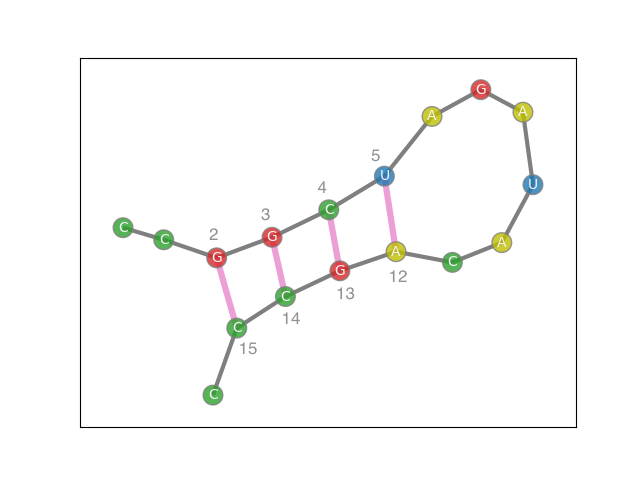
Fig.1 - An RNA sequence with a single stem of length 4.

Predicting the existence of stems is important to predicting the properties of the RNA molecule. However, prediction is complicated by two important factors.

First, stems are not allowed to overlap. A simple case of overlapping can be illustrated by Figure 1. The stem expressed by the pink lines can be denoted with the tuple (2, 5, 12, 15). Here, indexing starts with 0 at the far left C and continues along the sequence represented by the gray edges, ending with index 16 at the bottom-most C. The indices of the eight nucleotides in the stem are labeled in the figure. The four pink edges illustrate the four bonds that make up the stem. While there are eight nucleotides in the stem, bonded along pink lines, the 4-tuple completely determines the stem. However, the smaller stems (2, 4, 13, 15) and (3, 5, 12, 14) also need to be considered, even though the optimal solution will not include them in this case. Note that by default, we will only consider stems with length at least 3, as smaller stems are unlikely to form and sustain bonds.

Second, the intertwining phenomenon known as a pseudoknot is less energetically favorable. In Figure 2, we see an example of such a pseudoknot, where one side of a stem occurs in between the two sides of a different stem. The use of a quadratic objective allows us to make pseudoknots less likely to occur in optimal solutions, increasing overall accuracy. Specifically, we include a quadratic term for each pair of stems that, if present, form a pseudoknot. The positive coefficient on this quadratic term discourages the forming of pseudoknots without explicitly disallowing them.

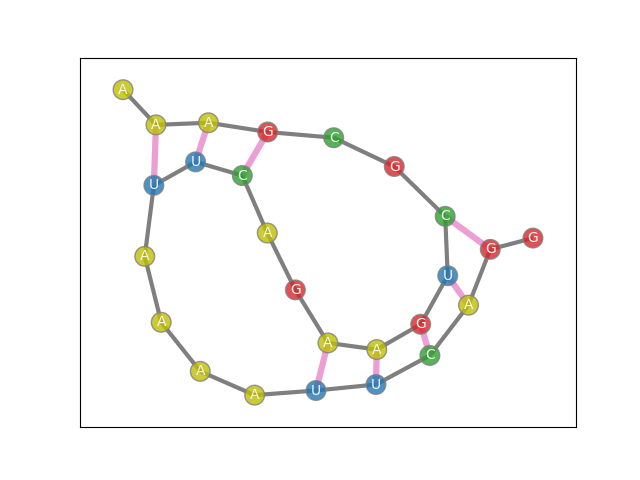
 Fig.2 - A pseudoknot formed by a stem of length 3 and a stem of length 5.

This demo is loosely based on the work in [1], which is in turn inspired by [2].

## Problem Formulation 

In predicting the stems of an RNA molecule, we build a quadratic model with three contributing factors.

1. Each potential stem is encoded as a binary variable, linearly weighted by the negative square of the length, k.

2. Each potential pseudoknot is encoded as a quadratic term, weighted by to the product of the two lengths times a positive parameter c.

3. Overlapping stems are not allowed. Potential overlaps give rise to constraints in the model.

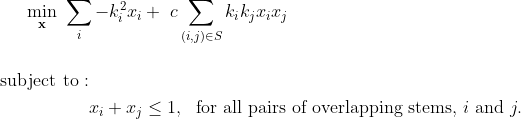

Here, each xi is a binary variable indicating the inclusion/exclusion of the ith stem. Each constant ki is the length of said stem. The indexing set S is the set of all pairs of stems that form a pseudoknot. Finally, c is a tunable parameter adjusting the impact of pseudoknots. It is set to 0.3 by default. If c = 0, the affect of pseudoknots is ignored, while c > 1 eliminates all pseudoknots from optimal solutions. This formulation (and default choice of c) is loosely based on [1].

In the printed solution, each stem is denoted by four numbers. The first two numbers correspond to the beginning and ending indices of the first side of the stem. Similarly, the last two numbers correspond to the beginning and ending indices of the second side of the stem.

## Code Specifics 

By default, the minimum stem length is set to 3. A stem of length 5 thus contains two stems of length 4 and three stems of length 3 under inclusion. The stem dictionary records the maximal stems (under inclusion) as keys, where each key maps to a list of the associated stems weakly contained within the maximal stem.

No two stems contained in the same maximal key can both be in an optimal solution, so we treat them all as overlapping, regardless of if it is literally the case. This particular case of overlapping is enforced by treating the set of stems contained in a maximal stem as a single discrete variable by use of the add_discrete method.

We further use the stem dictionary structure to avoid comparing all combinations of stems when searching for pseudoknots and overlaps.

Plotting uses a randomized process to find a reasonable layout. For this reason, the plot will change in successive runs, even if the solution does not.

Input text files should have a number at the beginning of each line, followed by a sequence of A, C, G, U, and T's. The file reader ignores the leading number and is not sensitive to spaces, upper vs. lower case, or line breaks. By convention, spaces are used to separate every 10 letters and the number at the beginning of each line is included to keep track of the location in the sequence. For instance, if there are 30 letters on each line, then there would be three groups of 10 letters on each line, with the leading numbers increasing by 30 each line.

## References 

[1] Fox DM, MacDermaid CM, Schreij AM, Zwierzyna M, Walker RC. "RNA folding using quantum computers," PLOS Computational Biology.

[2] Kai, Zhang, et al. "An efficient simulated annealing algorithm for the RNA secondary structure prediction with Pseudoknots," BMC Genomics.

## Code 

In [1]:
from collections import defaultdict
from itertools import product, combinations
import click
import matplotlib
import numpy as np
import networkx as nx
import dimod
import matplotlib.pyplot as plt
import dynex
import dimod

## Helper functions

Read properly formatted RNA text file and returns a matrix of possible hydrogen bonding pairs:

In [2]:
def text_to_matrix(file_name, min_loop):
    """ Reads properly formatted RNA text file and returns a matrix of possible hydrogen bonding pairs.

    Args:
        file_name (str):
            Path to text file.
        min_loop (int):
            Minimum number of nucleotides separating two sides of a stem.

    Returns:
        :class: `numpy.ndarray`:
            Numpy matrix of 0's and 1's, where 1 represents a possible bonding pair.
    """

    # Requires text file of RNA data written in same format as examples.
    with open(file_name) as f:
        rna = "".join(("".join(line.split()[1:]) for line in f.readlines())).lower()

    # Create a dictionary of all indices where each nucleotide occurs.
    index_dict = defaultdict(list)

    # Create a dictionary giving list of indices for each nucleotide.
    for i, nucleotide in enumerate(rna):
        index_dict[nucleotide].append(i)

    # List of possible hydrogen bonds for stems.
    # Recall that 't' is sometimes used as a stand-in for 'u'.
    hydrogen_bonds = [('a', 't'), ('a', 'u'), ('c', 'g'), ('g', 't'), ('g', 'u')]

    # Create a upper triangular 0/1 matrix indicating where bonds may occur.
    bond_matrix = np.zeros((len(rna), len(rna)), dtype=bool)
    for pair in hydrogen_bonds:
        for bond in product(index_dict[pair[0]], index_dict[pair[1]]):
            if abs(bond[0] - bond[1]) > min_loop:
                bond_matrix[min(bond), max(bond)] = 1

    return bond_matrix


Takes a matrix of potential hydrogen binding pairs and returns a dictionary of possible stems:

In [3]:
def make_stem_dict(bond_matrix, min_stem, min_loop):
    """ Takes a matrix of potential hydrogen binding pairs and returns a dictionary of possible stems.

    The stem dictionary records the maximal stems (under inclusion) as keys,
    where each key maps to a list of the associated stems weakly contained within the maximal stem.
    Recording stems in this manner allows for faster computations.

    Args:
        bond_matrix (:class: `numpy.ndarray`):
            Numpy matrix of 0's and 1's, where 1 represents a possible bonding pair.
        min_stem (int):
            Minimum number of nucleotides in each side of a stem.
        min_loop (int):
            Minimum number of nucleotides separating two sides of a stem.

    Returns:
        dict: Dictionary of all possible stems with maximal stems as keys.
    """

    stem_dict = {}
    n = bond_matrix.shape[0]

    # Iterate through matrix looking for possible stems.
    for i in range(n + 1 - (2 * min_stem + min_loop)):
        for j in range(i + 2 * min_stem + min_loop - 1, n):
            if bond_matrix[i, j]:
                k = 1
                # Check down and left for length of stem.
                # Note that bond_matrix is strictly upper triangular, so loop will terminate.
                while bond_matrix[i + k, j - k]:
                    bond_matrix[i + k, j - k] = False
                    k += 1

                if k >= min_stem:
                    # A 4-tuple is used to represent the stem.
                    stem_dict[(i, i + k - 1, j - k + 1, j)] = []

    # Iterate through all sub-stems weakly contained in a maximal stem under inclusion.
    for stem in stem_dict.keys():
        stem_dict[stem].extend([(stem[0] + i, stem[0] + k, stem[3] - k, stem[3] - i)
                                for i in range(stem[1] - stem[0] - min_stem + 2)
                                for k in range(i + min_stem - 1, stem[1] - stem[0] + 1)])

    return stem_dict

Checks if 2 stems use any of the same nucleotides:

In [4]:
def check_overlap(stem1, stem2):
    """ Checks if 2 stems use any of the same nucleotides.

    Args:
        stem1 (tuple):
            4-tuple containing stem information.
        stem2 (tuple):
            4-tuple containing stem information.

    Returns:
         bool: Boolean indicating if the two stems overlap.
    """

    # Check for string dummy variable used when implementing a discrete variable.
    if type(stem1) == str or type(stem2) == str:
        return False

    # Check if any endpoints of stem2 overlap with stem1.
    for val in stem2:
        if stem1[0] <= val <= stem1[1] or stem1[2] <= val <= stem1[3]:
            return True
    # Check if endpoints of stem1 overlap with stem2.
    # Do not need to check all stem1 endpoints.
    for val in stem1[1:3]:
        if stem2[0] <= val <= stem2[1] or stem2[2] <= val <= stem2[3]:
            return True

    return False


Creates a dictionary with all possible pseudoknots as keys and appropriate penalties as values. The penalty is the parameter c times the product of the lengths of the two stems in the knot.

In [5]:
def pseudoknot_terms(stem_dict, min_stem=3, c=0.3):
    """ Creates a dictionary with all possible pseudoknots as keys and appropriate penalties as values.

    The penalty is the parameter c times the product of the lengths of the two stems in the knot.

    Args:
        stem_dict (dict):
            Dictionary with maximal stems as keys and list of weakly contained sub-stems as values.
        min_stem (int):
            Smallest number of consecutive bonds to be considered a stem.
        c (float):
            Parameter factor of the penalty on pseudoknots.

    Returns:
         dict: Dictionary with all possible pseudoknots as keys and appropriate penalty as as value pair.
    """

    pseudos = {}
    # Look within all pairs of maximal stems for possible pseudoknots.
    for stem1, stem2 in product(stem_dict.keys(), stem_dict.keys()):
        # Using product instead of combinations allows for short asymmetric checks.
        if stem1[0] + 2 * min_stem < stem2[1] and stem1[2] + 2 * min_stem < stem2[3]:
            pseudos.update({(substem1, substem2): c * (1 + substem1[1] - substem1[0]) * (1 + substem2[1] - substem2[0])
                            for substem1, substem2
                            in product(stem_dict[stem1], stem_dict[stem2])
                            if substem1[1] < substem2[0] and substem2[1] < substem1[2] and substem1[3] < substem2[2]})
    return pseudos

Creates a constrained quadratic model to optimize most likely stems from a dictionary of possible stems:

In [6]:
def build_cqm(stem_dict, min_stem, c):
    """ Creates a constrained quadratic model to optimize most likely stems from a dictionary of possible stems.

    Args:
        stem_dict (dict):
            Dictionary with maximal stems as keys and list of weakly contained sub-stems as values.
        min_stem (int):
            Smallest number of consecutive bonds to be considered a stem.
        c (float):
            Parameter factor of the penalty on pseudoknots.

    Returns:
         :class:`~dimod.ConstrainedQuadraticModel`: Optimization model for RNA folding.
    """

    # Create linear coefficients of -k^2, prioritizing inclusion of long stems.
    # We depart from the reference paper in this formulation.
    linear_coeffs = {stem: -1 * (stem[1] - stem[0] + 1) ** 2 for sublist in stem_dict.values() for stem in sublist}

    # Create constraints for overlapping and and sub-stem containment.
    quadratic_coeffs = pseudoknot_terms(stem_dict, min_stem=min_stem, c=c)

    bqm = dimod.BinaryQuadraticModel(linear_coeffs, quadratic_coeffs, 'BINARY')

    cqm = dimod.ConstrainedQuadraticModel()
    cqm.set_objective(bqm)

    # Add constraint disallowing overlapping sub-stems included in same maximal stem.
    for stem, substems in stem_dict.items():
        if len(substems) > 1:
            # Add the variable for all zeros case in one-hot constraint
            zeros = 'Null:' + str(stem)
            cqm.add_variable(zeros, 'BINARY')
            cqm.add_discrete(substems + [zeros], stem)

    for stem1, stem2 in combinations(stem_dict.keys(), 2):
        # Check maximal stems first.
        if check_overlap(stem1, stem2):
            # If maximal stems overlap, compare list of smaller stems.
            for stem_pair in product(stem_dict[stem1], stem_dict[stem2]):
                if check_overlap(stem_pair[0], stem_pair[1]):
                    cqm.add_constraint(dimod.quicksum([dimod.Binary(stem) for stem in stem_pair]) <= 1)

    return cqm

## RNA Folding Example: Tobacco Mild Greed Mosaic Virus

The folder 'rna-data' contains multiple RNA sequences, including the HIV virus. For demonstration purposes we are using the "Tobamovirus", which is the Tobacco Mild Green Mosaic Virus:

https://rnavlab.utep.edu/static/PKB_files/PKB92

By default, the minimum stem length is set to 3. A stem of length 5 thus contains two stems of length 4 and three stems of length 3 under inclusion. The stem dictionary records the maximal stems (under inclusion) as keys, where each key maps to a list of the associated stems weakly contained within the maximal stem.

No two stems contained in the same maximal key can both be in an optimal solution, so we treat them all as overlapping, regardless of if it is literally the case. This particular case of overlapping is enforced by treating the set of stems contained in a maximal stem as a single discrete variable by use of the add_discrete method.

We further use the stem dictionary structure to avoid comparing all combinations of stems when searching for pseudoknots and overlaps. First we define the parameters:

In [7]:
# Defining the parameters:
path     = "rna-data/TMGMV_UPD-PK1.txt"
min_stem = 3 # Minimum length for a stem to be considered
min_loop = 2 # Minimum number of nucleotides separating two sides of a stem
c = 0.3      # Multiplier for the coefficient of the quadratic terms for pseudoknots

Then we load the RNA sequence and convert it into a matrix. Input text files should have a number at the beginning of each line, followed by a sequence of A, C, G, U, and T's. The file reader ignores the leading number and is not sensitive to spaces, upper vs. lower case, or line breaks. By convention, spaces are used to separate every 10 letters and the number at the beginning of each line is included to keep track of the location in the sequence. For instance, if there are 30 letters on each line, then there would be three groups of 10 letters on each line, with the leading numbers increasing by 30 each line.

In [8]:
# load RNA sequence:
matrix = text_to_matrix(path, min_loop)
stem_dict = make_stem_dict(matrix, min_stem, min_loop)

The problem can be expresses as a Constrained Quadratic Model (CQM):

In [9]:
cqm = build_cqm(stem_dict, min_stem, c)

<ipython-input-6-343e14dbb60c>:33: DeprecationWarning: Parameter order CQM.add_variable(v, vartype) is deprecated since dimod 0.11.0 and will be removed in 0.13.0. Use CQM.add_variable(vartype, v) instead.
  cqm.add_variable(zeros, 'BINARY')


Binary Quadratic Models (BQM) and Constrained Quadratic Models can be easily converted between each other. Here a 2-tuple containing a binary quadratic model and a function that converts samples over the binary quadratic model back into samples for the constrained quadratic model is returned:

In [28]:
bqm, invert = dimod.cqm_to_bqm(cqm) # Convert CQM->BQM

Next we sample the (converted) CQM problem on the Dynex neuromorphic platform to find the optimal state witht the lowest energy using Ising/QUBU sampling. We choose to run the computation on 1024 individual Dynex chips for an integration time of maximum 1000 steps. Note that the Dynex platform supports up to 150 million individual Dynex chips (at the time of writing this example)

In [42]:
# run on Dynex:
model = dynex.BQM(bqm);
sampler = dynex.DynexSampler(model);

In [45]:
sampleset = sampler.sample(num_reads=1024, annealing_time = 1000);
sample_set = invert(sampler.assignments); # return to original CQM variable classes

time: 0.05s #workers: 2 #chips: 1152 #steps: 1010 global falsified softs: 15 global energy: 199270.0
FINISHED READ AFTER 0.05 SECONDS
SAMPLESET LOADED
MALLOB: JOB UPDATED: 285


sampler.assignments contains the best assignment which was found by the Dynex sampler. We will be using this assignment to extract the stems and find the pseudoknots:

In [47]:
# Extract best feasible sample.
solution = sample_set 

# Extract stems with a positive indicator variable.
bonded_stems = [stem for stem, val in solution.items() if val == 1 and type(stem) == tuple]

print('\nNumber of stems in best solution:', len(bonded_stems))
print('Stems in best solution:', *bonded_stems)

print('\nNumber of variables (stems):', len(solution))

# Find pseudoknots using product instead of combinations allows for short asymmetric checks.
pseudoknots = [(stem1, stem2) for [stem1, stem2] in product(bonded_stems, bonded_stems)
               if stem1[1] < stem2[0] and stem2[1] < stem1[2] and stem1[3] < stem2[2]]

print('\nNumber of pseudoknots in best solution:', len(pseudoknots))
if pseudoknots:
    print('Pseudoknots:', *pseudoknots)



Number of stems in best solution: 2
Stems in best solution: (2, 4, 20, 22) (14, 16, 24, 26)

Number of variables (stems): 17

Number of pseudoknots in best solution: 1
Pseudoknots: ((2, 4, 20, 22), (14, 16, 24, 26))


Now we will visualize the found solution. Note that plotting uses a randomized process to find a reasonable layout. For this reason, the plot will change in successive runs, even if the solution does not.

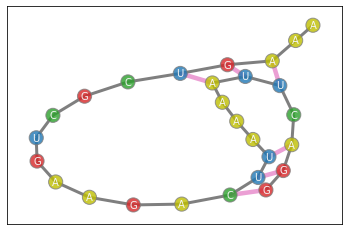

In [52]:
with open(path) as f:
    rna = "".join(("".join(line.split()[1:]) for line in f.readlines())).lower()
    
# Create graph with edges from RNA sequence and stems. Nodes are temporarily labeled by integers.
G = nx.Graph()
rna_edges = [(i, i + 1) for i in range(len(rna) - 1)]
stem_edges = [(stem[0] + i, stem[3] - i) for stem in bonded_stems for i in range(stem[1] - stem[0] + 1)]
G.add_edges_from(rna_edges + stem_edges)

# Assign each nucleotide to a color.
color_map = []
for node in rna:
    if node == 'g':
        color_map.append('tab:red')
    elif node == 'c':
        color_map.append('tab:green')
    elif node == 'a':
        color_map.append('y')
    else:
        color_map.append('tab:blue')

options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.8}

pos = nx.spring_layout(G, iterations=5000)  # max(3000, 125 * len(rna)))
nx.draw_networkx_nodes(G, pos, node_color=color_map, **options)
labels = {i: rna[i].upper() for i in range(len(rna))}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="whitesmoke")
nx.draw_networkx_edges(G, pos, edgelist=rna_edges, width=3.0, alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=stem_edges, width=4.5, alpha=0.7, edge_color='tab:pink')